In [5]:
import numpy as np
import pandas as pd 
import os
#print(os.listdir("../input"))

from string import punctuation
from keras.models import Sequential,Model
from keras.layers import Embedding,Input,Activation,Flatten,CuDNNLSTM,Dense,Dropout,Bidirectional
from keras.layers import Convolution1D,GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import gc
import seaborn as sns
%matplotlib inline
tqdm.pandas()

Using TensorFlow backend.


In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd 
train_df=pd.read_csv('gdrive/My Drive/train.csv')

Reading the CSV

In [8]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


**Converting Target Probabilities to 0 or 1 for making it categorical. All the values in target column that are above 0.5 are considered as 1 and rest are considered as 0.**

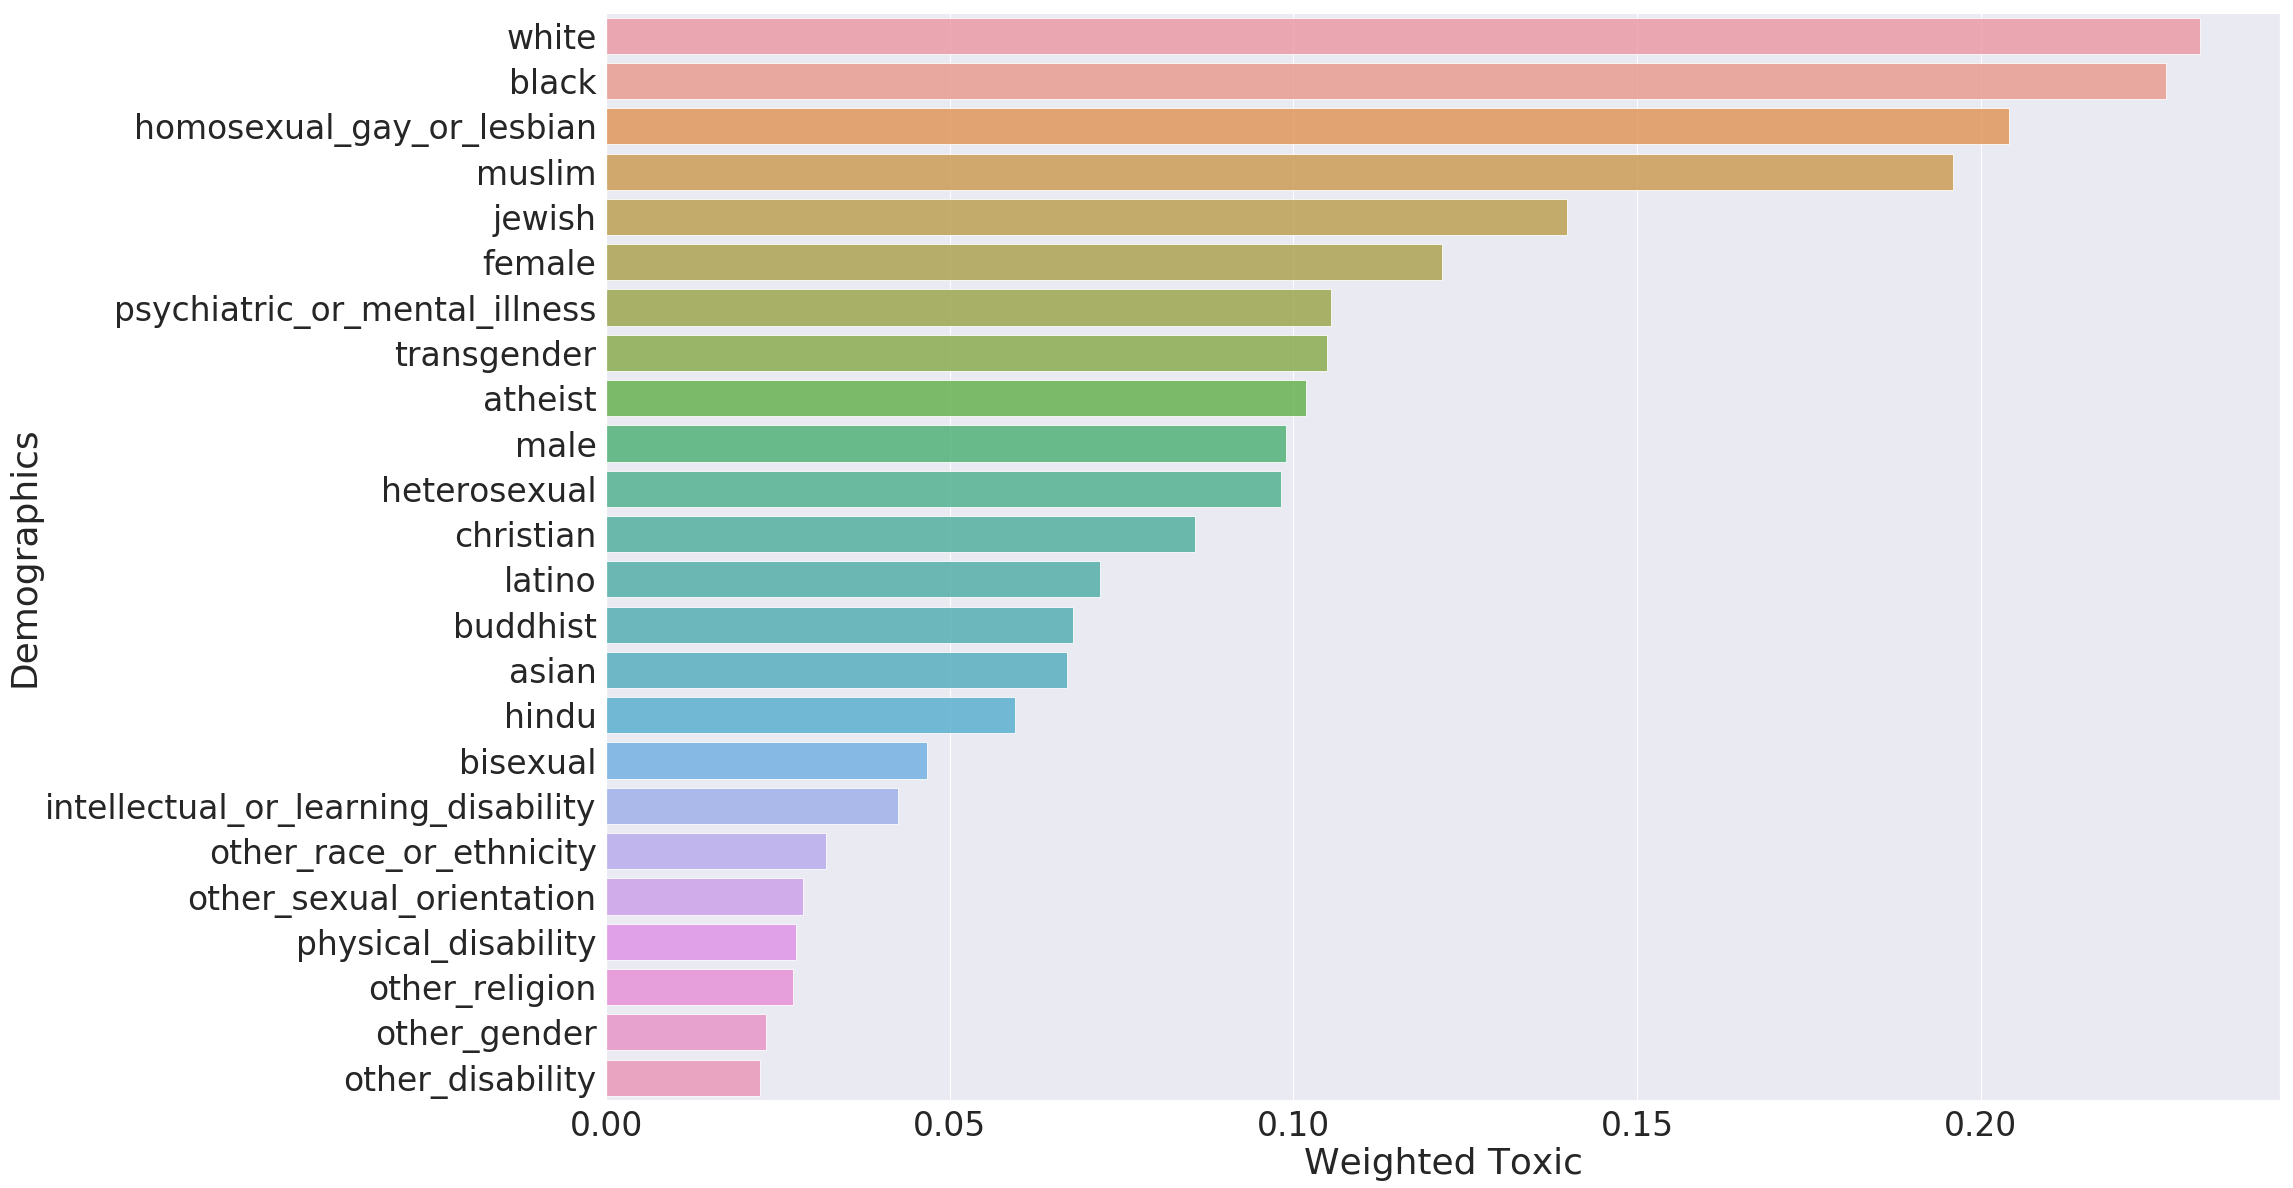

In [9]:
#Source:simple-eda-text-preprocessing-jigsaw
import matplotlib.pyplot as plt
import seaborn as sns
demographics = train_df.loc[:, ['target']+list(train_df)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()
del sns,weighted_toxic,demographics,ax

In [0]:
def target(value):
    if value>=0.5:
        return 1
    else:
        return 0

In [0]:
train_df['target'] = train_df['target'].apply(target)

**Getting out X and y variable. We will be training on the X variable and predicting the Y variable**

In [0]:
x = train_df['comment_text']
y = train_df['target']

**Using seaborn library to check the number of observations in each class that is 0 and 1. Countplot helps in visualization of the values.**

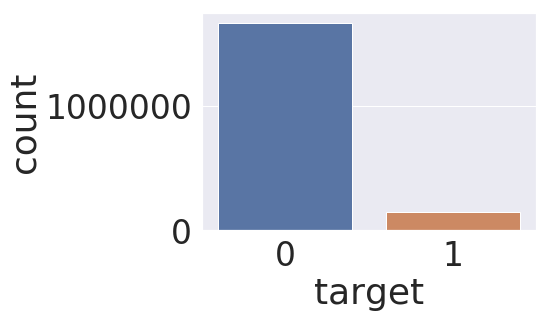

In [13]:
import seaborn as sns
sns.countplot(y)

**Performing some cleaning in the commnet text using regular expression. This code with help us extract only the characters from the expression.
**
**Tutorial for regular expressions can be found** [here](https://www.w3schools.com/python/python_regex.asp)

In [0]:
def cleaning(text):
    text = text.lower()
    text = re.sub(r'\W+',' ',text)
    return text

In [15]:
x = x.progress_apply(cleaning)

100%|██████████| 1804874/1804874 [00:35<00:00, 51282.55it/s]


**Using word embeddings so that words with similar words have similar representation in vector space. It represents every word as a vector. The words which have similar meaning are place close to each other. Quick understanding can be done from [this](https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795) article.**

In [16]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
f = open('gdrive/My Drive/glove.6B.100d.txt',encoding="utf8")

In [18]:

embedding_values = {}
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_values[word]=coef

400000it [00:10, 38974.97it/s]


**These are the steps that needs to be performed so that we can convert each word of our vocabulary into a unique integer. Tokenizer is initalized in first step. Then fitting on the text will help us create a vocabulary so that each word is assigned with a unique integer. Then we convert in the whole sentence of the comment into a sequence of numbers which are assigned by the tokenizer.**

In [19]:
token = Tokenizer()
token.fit_on_texts(x)
sequence = token.texts_to_sequences(x)
len(sequence)

1804874

In [0]:
vocab_size = len(sequence)+1

**Padding the sequence helps in making all the sentence of same length. maxlen is the parameter which decides the length we want to assign to all the sentences. Padding is done by adding 0 on either the end of sentence or prior the sentence if the sentence is having length less than max length. This is also a parameter which user can change, by defaults its prefix. If the length of the sentence is more than 100 then it is pruned which brings down the length to 100 (maxlen)**

In [0]:
pad_seq = pad_sequences(sequence,maxlen = 100)

**Now we will be converting each word in our vocabulary into word embeddings. This embedding is vector of 1x100 dimension which represents each word as a vector and placing them into a vector space. Embedding matrix is created in which the number assigned to the word by tokenizer is assigned with the corresponding vector which we get from the glove embeddings.**

In [22]:
embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(token.word_index.items()):
    values = embedding_values.get(word)
    if values is not None:
        embedding_matrix[i] = values

100%|██████████| 309011/309011 [00:00<00:00, 591398.04it/s]


Now we start building the model with Keras

In [0]:
model = Sequential()

Here this embedding layer is important as this will help us in training of the sentences with their respective embeddings whihc we have assigned above. The first parameter is the size of our vocabulary. Second parameter is the output embeddings length which is 100 in this case as we used the 100 glove embeddings of each word. The length of each observation which is expected by the network is given by input_length parameter. We have padded all the observations to 100 hence we set input_length = 10. Weights parameter shows that the embeddings which we want to use is embeddings_matrix and it should not be altered hence trainable is kept false.
If we want to train our own embeddings we can simply remove the weights and trainable parameter.

In [24]:
model.add(Embedding(vocab_size,100,input_length = 100,weights = [embedding_matrix],trainable = False))

Instructions for updating:
Colocations handled automatically by placer.


Building a LSTM model. LSTM networks are useful in sequence data as they are capable of remembering the past words which help them in understanding the meaning of the sentence which helps in text classification. Bidirectional Layer is helpful as it helps in understanding thesentence from start to end and also from end to start. It works in both the direction. This is useful as the reverse order LSTM layer is capable of learning patterns which are not possible for the normal LSTM layers which goes from start to end of the sentence in the normal order. Hence Bidirectional layers are useful in text classification problems as different patterns can be captured from 2 directions.
CuDNNLSTM is same as LSTM. If you are using GPU then CuDNNLSTM will be faster but if you are using CPU please use LSTM.

In [25]:
# Sentence Via Biderectional LSTM
model=Sequential()
model.add(Embedding(vocab_size,100,input_length = 100,weights = [embedding_matrix],trainable = False))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(1,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          180487500 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          161600    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 180,674,957
Trainable params: 187,457
Non-trainable params: 180,487,500
_________________________________________________________________


In [0]:
x_train,x_test,y_train,y_test = train_test_split(pad_seq,y,test_size = 0.15,random_state = 42)

In [0]:
history=model.fit(x_train,y_train,epochs=10,batch_size=1000,validation_data=(x_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1534142 samples, validate on 270732 samples
Epoch 1/10
1534142/1534142 [==============================] - 117s 76us/step - loss: 14.6687 - acc: 0.0799 - val_loss: 14.6607 - val_acc: 0.0804
Epoch 2/10
 194000/1534142 [==>...........................] - ETA: 1:32 - loss: 14.6565 - acc: 0.0807

In [0]:
values = history.history
validation_acc = values['val_acc']
training_acc = values['acc']
validation_loss = values['loss']
training_loss = values['val_loss']
epochs = range(10)

Plotting a graph between Training and Testing Accuracy

In [0]:
plt.plot(epochs,training_acc,label = 'Training Accuracy')
plt.plot(epochs,validation_acc,label = 'Validation Accuracy')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plotting a graph between Training and Testing Loss

In [0]:
plt.plot(epochs,training_loss,label = 'Training Loss')
plt.plot(epochs,validation_loss,label = 'Validation Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
import pandas as pd 
test_df=pd.read_csv('gdrive/My Drive/text.csv')

In [0]:
test_df.head()

In [0]:
X = test_df['comment_text']

Preprocessing of the test data so that model can easily make its prediction as it should be in the same format as that of our training data.
Note that we are using the same tokenizer in our testing and we are not fitting it again becuase this might change the numbers assigned to words which are there in the training data.

In [0]:
test_df_sequence = token.texts_to_sequences(X)
test_df_pad_seq = pad_sequences(test_df_sequence,maxlen = 100)

In [0]:
prediction = model.predict(test_df_pad_seq)

In [0]:
submission = pd.DataFrame([test_df['id']]).T
submission['prediction'] = prediction

In [0]:
submission.to_csv('submission.csv', index=False)

In [0]:
submission.head()